# Data Preparation Overview

**Briefly Mentioned by Teammate**

**Script**:  
Before proceeding with modeling, our **Data Engineer** prepared the dataset by collecting and standardizing images of big cat subspecies. The dataset includes classes such as **Bengal Tiger**, **Siberian Tiger**, **African Lion**, and others. Care was taken to ensure high-resolution and balanced samples for each class, enabling a robust foundation for model training and evaluation.


## Import Necessary Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

2025-01-16 21:55:28.629342: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-16 21:55:28.968016: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737035729.069090    1287 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737035729.098622    1287 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-16 21:55:29.334878: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

# Data Augmentation

**Script**:  
To enhance our dataset, I applied **data augmentation techniques** to artificially expand the diversity of images. These techniques include:

- **Rescaling**: Normalizing pixel values to standardize images.  
- **Transformations**: Applying rotations, flips, and zooms to create variations in image orientation.  
- **Shifting and Shearing**: Simulating various perspectives to increase dataset variability.

These augmentations not only help prevent overfitting but also improve the model's robustness by exposing it to a wider range of scenarios.


In [16]:
# Path to dataset
data_path = r"kucing_besaq/"

# Image dimensions
height, width = 450, 240  # Input image dimensions
input_size = 3 * height * width  # For RGB images
print(f"Calculated input size for RGB: {input_size}")

# Data augmentation and preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    validation_split=0.2,  # 20% of the dataset for validation
    rotation_range=30,  # Randomly rotate images
    width_shift_range=0.2,  # Horizontally shift images
    height_shift_range=0.2,  # Vertically shift images
    shear_range=0.2,  # Shear transformations
    zoom_range=0.2,  # Random zoom in/out
    horizontal_flip=True  # Flip images horizontally
)

Calculated input size for RGB: 324000


# Loading and Preparing the Dataset

This section demonstrates how the dataset is loaded and split into training and validation subsets using data generators. The process is outlined as follows:

### Code Explanation:

1. **Function Definition**:
   - `train_test_generators(data_path)`: A function to create training and validation data generators from the specified dataset directory.

2. **Training Data Generator**:
   - Uses the `flow_from_directory` method to load images from the training subset.
   - Parameters:
     - `target_size`: Resizes images to the specified height and width.
     - `batch_size`: Defines the number of images per batch (set to 32 by default for balance between memory usage and training speed).
     - `class_mode`: Set to `'categorical'` for multi-class classification tasks.
     - `subset`: Set to `'training'` to load training data.

3. **Validation Data Generator**:
   - Similar to the training generator but with `subset` set to `'validation'` to load validation data.

4. **Return Statement**:
   - Returns both the training and validation generators for use in model training.

### Usage:
```python
train_gen, val_gen = train_test_generators(data_path)


In [17]:
# Load dataset
def train_test_generators(data_path):
    train_gen = datagen.flow_from_directory(
    data_path,
    target_size=(height, width),
    batch_size=32,  # Adjust based on memory and training speed
    class_mode='categorical',  # Use 'categorical' for multi-class classification
    subset='training'
)

    val_gen = datagen.flow_from_directory(
        data_path,
        target_size=(height, width),
        batch_size=32,
        class_mode='categorical',
        subset='validation'
        )
    return train_gen, val_gen

train_gen, val_gen = train_test_generators(data_path)

Found 8000 images belonging to 8 classes.
Found 2000 images belonging to 8 classes.


# Detecting Output Classes

This section demonstrates how to determine the number of classes in the dataset and their corresponding labels.

### Code Explanation:

1. **Retrieve Class Indices**:
   - The `train_gen.class_indices` attribute provides a dictionary mapping class names to their respective numeric labels.

2. **Calculate Output Size**:
   - `output_size` is determined by taking the length of `train_gen.class_indices`, representing the total number of classes.

3. **Display Results**:
   - Prints the total number of detected classes and their corresponding mappings.

### Example Output:
```python
Detected 4 classes: {'Bengal Tiger': 0, 'Siberian Tiger': 1, 'African Lion': 2, 'Jaguar': 3}


In [18]:
output_size = len(train_gen.class_indices)
print(f"Detected {output_size} classes: {train_gen.class_indices}")

Detected 8 classes: {'african_leopard': 0, 'african_lion': 1, 'amur_leopard': 2, 'asiatic_lion': 3, 'bengal_tiger': 4, 'jaguar': 5, 'siberian_tiger': 6, 'sumatran_tiger': 7}


# Model Architecture: Transfer Learning with MobileNetV2

This section outlines the process of creating a custom model using **MobileNetV2** as the base model with additional layers for classification.

### Steps:

1. **Load Pre-trained MobileNetV2**:
   - `MobileNetV2(weights='imagenet', include_top=False, input_shape=(height, width, 3))`:  
     Loads the MobileNetV2 model pre-trained on the ImageNet dataset, excluding the fully connected (top) layers.  
     The input shape is set to `(height, width, 3)` to match the dataset dimensions.

2. **Add Custom Layers**:
   - **Global Average Pooling**: Reduces the feature maps to a fixed-length vector (`GlobalAveragePooling2D`).
   - **Dense Layer**: Adds a fully connected layer with 128 neurons and ReLU activation for learning non-linear representations.
   - **Dropout**: Adds a dropout layer (`0.5`) to reduce overfitting by randomly disabling neurons during training.
   - **Output Layer**: Adds a dense layer with `output_size` neurons (equal to the number of classes) and a softmax activation function for multi-class classification.

3. **Freeze Base Model Layers**:
   - Loops through the layers of `MobileNetV2` and sets `layer.trainable = False` to prevent updating the pre-trained weights during training.

4. **Compile the Model**:
   - **Optimizer**: Uses `adam` for adaptive learning.
   - **Loss Function**: `categorical_crossentropy` for multi-class classification.
   - **Metrics**: Tracks accuracy during training and evaluation.

### Final Model Creation:
```python
model = Model(inputs=init_model.input, outputs=predictions)


In [19]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

init_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(height, width, 3))

x = init_model.output
x = GlobalAveragePooling2D()(x)  # Reduces feature maps to a vector
x = Dense(128, activation='relu')(x)  # Fully connected layer
x = Dropout(0.5)(x)  # Dropout for regularization
predictions = Dense(output_size, activation='softmax')(x)  # Final output layer with softmax activation

# Create the final model
model = Model(inputs=init_model.input, outputs=predictions)
for layer in init_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/tmp/ipykernel_12456/836906246.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  init_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(height, width, 3))


# Model Training with Callbacks

This section explains how to train the model using specified callbacks for improved performance and resource efficiency.

### Steps:

1. **Define Callbacks**:
   - **ModelCheckpoint**:
     - Saves the model to a file (`kucing.keras`) when the validation accuracy improves.
     - Parameters:
       - `monitor="val_accuracy"`: Monitors validation accuracy.
       - `save_best_only=True`: Saves only the best model based on monitored performance.
       - `verbose=1`: Provides detailed logging.
   - **EarlyStopping**:
     - Stops training early if the validation loss does not improve for a specified number of epochs.
     - Parameters:
       - `monitor="val_loss"`: Monitors validation loss.
       - `patience=5`: Waits for 5 epochs without improvement before stopping.
       - `verbose=1`: Logs when early stopping is triggered.

2. **Calculate Steps**:
   - **Steps per Epoch**:
     - `steps_per_epoch = train_gen.samples // train_gen.batch_size`: Defines the number of steps for training in each epoch.
   - **Validation Steps**:
     - `validation_steps = val_gen.samples // val_gen.batch_size`: Defines the number of steps for validation in each epoch.

3. **Train the Model**:
   - **`model.fit`**:
     - Trains the model using the training and validation data generators.
     - Key Parameters:
       - `steps_per_epoch`: Number of training steps per epoch.
       - `epochs=10`: Sets a maximum of 10 epochs, leaving room for early stopping.
       - `validation_data`: Uses the validation generator for evaluation during training.
       - `validation_steps`: Number of validation steps per epoch.
       - `callbacks`: Includes `ModelCheckpoint` and `EarlyStopping` for monitoring and control.

4. **Track Training Progress**:
   - The `history` object stores the training and validation metrics for analysis.

### Example Usage:
```python
history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    validation_data=val_gen,
    validation_steps=validation_steps,
    callbacks=[checkpoint, early_stop]
)


In [20]:

# Define callbacks
checkpoint = ModelCheckpoint("kucing.keras", 
                            monitor="val_accuracy", save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=5, verbose=1)

# Calculate steps per epoch and validation steps
steps_per_epoch = train_gen.samples // train_gen.batch_size
validation_steps = val_gen.samples // val_gen.batch_size

# Train the model
history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=10,  # Allow room for EarlyStopping
    validation_data=val_gen,
    validation_steps=validation_steps,
    callbacks=[checkpoint, early_stop]
)

/home/cyberpvt/Pai/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


2025-01-16 16:55:56.922961: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1680_0', 112 bytes spill stores, 144 bytes spill loads

2025-01-16 16:55:57.763002: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1680', 228 bytes spill stores, 228 bytes spill loads

2025-01-16 16:55:57.958483: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4652', 24 bytes spill stores, 24 bytes spill loads

2025-01-16 16:55:58.483933: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4652', 60 bytes spill stores, 64 bytes spill loads

2025-01-16 16:55:58.505710: I external/local_xla/xla/s

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 915ms/step - accuracy: 0.5071 - loss: 1.3432
Epoch 1: val_accuracy improved from -inf to 0.73841, saving model to kucing.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 328s 1s/step - accuracy: 0.5075 - loss: 1.3418 - val_accuracy: 0.7384 - val_loss: 0.6120
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 872ms/step - accuracy: 0.7342 - loss: 0.6617
Epoch 2: val_accuracy improved from 0.73841 to 0.77016, saving model to kucing.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 275s 1s/step - accuracy: 0.7343 - loss: 0.6615 - val_accuracy: 0.7702 - val_loss: 0.5158
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 995ms/step - accuracy: 0.7847 - loss: 0.5540
Epoch 3: val_accuracy improved from 0.77016 to 0.79183, saving model to kucing.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 300s 1s/step - accuracy: 0.7847 - loss: 0.5540 - val_accuracy: 0.7918 - val_loss: 0.4770
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 852ms/step - accuracy: 0.7903 - loss: 0.5040
Epoch 4: val_accuracy improved from 0.79183 to 0.7938

# Save the Trained Model

After completing the training process, the final model is saved to a file for future use. This ensures that the trained model can be easily loaded and reused without needing to retrain.

### Code Explanation:

- **Save the Model**:
  - `model.save("kucing.keras")`: Saves the trained model in the **Keras format** to the file `kucing.keras`.

### Why Save the Model?
1. **Reusability**:
   - The saved model can be reloaded to make predictions or further fine-tune without retraining.
2. **Portability**:
   - The model file can be shared or deployed to different environments for inference.
3. **Checkpointing**:
   - Serves as a backup of the trained model, preserving its weights and architecture.

### Example Usage:
To reload the saved model later:
```python
from tensorflow.keras.models import load_model

model = load_model("kucing.keras")


In [21]:
model.save("kucing.keras")

# Loading and Evaluating the Best Model

After training, the best-performing model is loaded for evaluation on the validation dataset to verify its performance.

### Steps:

1. **Load the Best Model**:
   - `tf.keras.models.load_model("kucing.keras")`:  
     Loads the saved model file (`kucing.keras`) into the `best_model` variable. This model corresponds to the checkpoint with the highest validation accuracy.

2. **Evaluate the Model**:
   - **Validation Loss and Accuracy**:
     - `best_model.evaluate(val_gen)`:  
       Evaluates the model on the validation data generator and computes the validation loss and accuracy.

3. **Print Results**:
   - Displays the validation loss and accuracy in a formatted output for easy interpretation.

### Example Output:
```python
Best model validation loss: 0.3565
Best model validation accuracy: 0.8430


In [22]:
# Load the best saved model
best_model = tf.keras.models.load_model("kucing.keras")

# Evaluate the best model
val_loss, val_acc = best_model.evaluate(val_gen)
print(f"Best model validation loss: {val_loss:.4f}")
print(f"Best model validation accuracy: {val_acc:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 784ms/step - accuracy: 0.8377 - loss: 0.3808
Best model validation loss: 0.3656
Best model validation accuracy: 0.8430


# Visualizing Model Predictions

This script visualizes the model's predictions on a few random samples from the validation set, comparing them with the actual labels.

### Steps:

1. **Load the Trained Model**:
   - `model = load_model('kucing.keras')`: Loads the saved model for inference.

2. **Map Class Indices to Class Names**:
   - `train_gen.class_indices`: Provides the mapping of class names to their respective indices.
   - `index_to_class`: Reverses the mapping to convert indices back to class names.

3. **Select Random Samples**:
   - `np.random.choice`: Randomly selects `num_samples_to_display` indices from the validation set.

4. **Predict and Compare**:
   - For each selected sample:
     - Retrieve the image and label from the validation generator.
     - Use `model.predict` to predict the class probabilities.
     - Convert both the predicted and actual indices to class names.
     - Display the image along with the predicted (`P`) and actual (`A`) labels.

5. **Visualize Results**:
   - **Matplotlib**:
     - Displays images in a grid format with titles showing predicted and actual labels.
     - `plt.tight_layout`: Adjusts spacing between subplots for better visualization.

6. **Calculate Accuracy**:
   - Counts the number of correct predictions and computes the percentage accuracy over the displayed samples.

### Example Output:
- **Visualization**: A row of images with predicted and actual labels displayed as:


2025-01-16 17:46:48.033828: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng56{k2=0,k12=3,k13=2,k14=2,k15=0,k17=144,k18=0,k22=0,k23=0} for conv (f32[1,160,15,8]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,576,15,8]{3,2,1,0}, f32[160,576,1,1]{3,2,1,0}), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-01-16 17:46:48.038090: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.456849769s
Trying algorithm eng56{k2=0,k12=3,k13=2,k14=2,k15=0,k17=144,k18=0,k22=0,k23=0} for conv (f32[1,160,15,8]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,576,15,8]{3,2,1,0}, f32[160,576,1,1]{3,2,1,0}), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


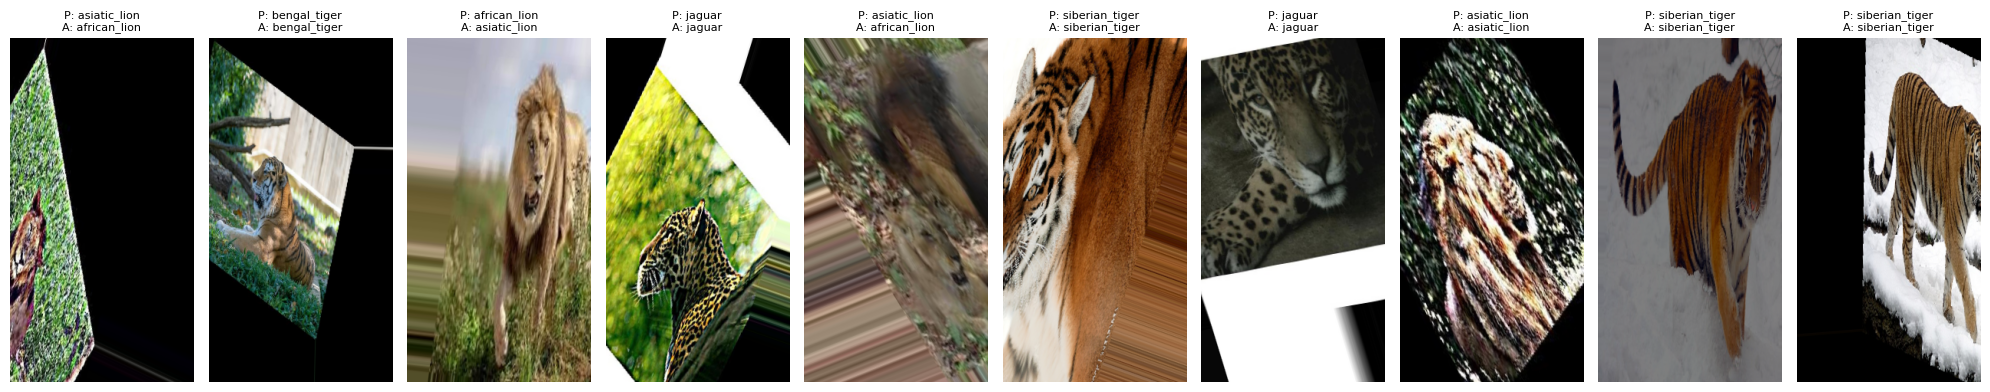

Accuracy = 70.0%


In [23]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model

# Load the model
model = load_model('kucing.keras')

# Map class indices to class names (from training data)
class_indices = train_gen.class_indices
index_to_class = {v: k for k, v in class_indices.items()}  # Reverse dictionary for index to class mapping

# Choose a few random samples from the validation set
num_samples_to_display = 10
sample_indices = np.random.choice(len(val_gen), num_samples_to_display, replace=False)
count = 0

# Display the samples and their predicted and actual labels
fig, axes = plt.subplots(1, num_samples_to_display, figsize=(20, 4))
for i, ax in enumerate(axes.flat):
    sample_index = sample_indices[i]
    image, label = val_gen[sample_index]
    
    # Extract individual image and label from batch
    image = image[0]
    label = np.argmax(label[0])  # Convert one-hot label to integer
    
    # Make prediction using the model
    prediction = model.predict(np.expand_dims(image, axis=0))  # Expand dims for prediction
    predicted_label = np.argmax(prediction[0])  # Get the index of the highest probability
    
    # Convert indices to class names
    actual_class = index_to_class[label]
    predicted_class = index_to_class[predicted_label]
    
    ax.imshow(image, cmap='gray')
    ax.set_title(f"P: {predicted_class}\nA: {actual_class}", fontsize=8)  # Use multiline and smaller font
    ax.axis('off')
    if predicted_label == label:
        count += 1

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

print(f"Accuracy = {(count / num_samples_to_display) * 100}%")

# Predicting and Visualizing Model Output on Custom Images

This script processes and predicts the class labels for custom test images located in a specified directory. The results are displayed in a grid format along with the model's predictions and confidence scores.

### Steps:

1. **Preprocess Images**:
   - `preprocess_image(img_path, target_size)`:
     - Loads an image from the provided path and resizes it to the target size.
     - Converts the image to a normalized NumPy array.
     - Adds a batch dimension for model input.

2. **Define Test Image Directory**:
   - `test_image_dir`: Path to the directory containing custom test images.
   - Filters files with common image extensions (e.g., `.jpg`, `.png`, `.bmp`, etc.).

3. **Load Trained Model**:
   - `tf.keras.models.load_model('kucing.keras')`: Loads the trained model for prediction.

4. **Map Class Indices to Labels**:
   - Retrieves class labels from the training generator (`train_gen.class_indices`) and reverses the mapping.

5. **Predict and Visualize**:
   - Iterates through the test images:
     - Preprocesses each image.
     - Predicts the class and confidence score using the trained model.
     - Displays the image along with the predicted class and confidence score.

6. **Configure Grid Layout**:
   - Dynamically calculates the number of rows and columns based on the total number of images and specified column count (`cols`).
   - Handles unused subplots by turning them off.

7. **Display Results**:
   - Uses Matplotlib to display images in a grid format.
   - Includes titles for each subplot showing:
     - Predicted class
     - Confidence score (e.g., `Predicted: Bengal Tiger\nConfidence: 95.45%`).

### Example Use Case:
This script is ideal for testing the model's performance on unseen images, providing visual feedback on predictions and confidence levels. 

### Sample Output:
A grid of images with their corresponding predictions and confidence levels displayed as subplot titles.

### Notes:
- Ensure the `test_image_dir` contains only valid image files.
- Adjust `cols` to control the number of columns in the grid for better visualization.


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


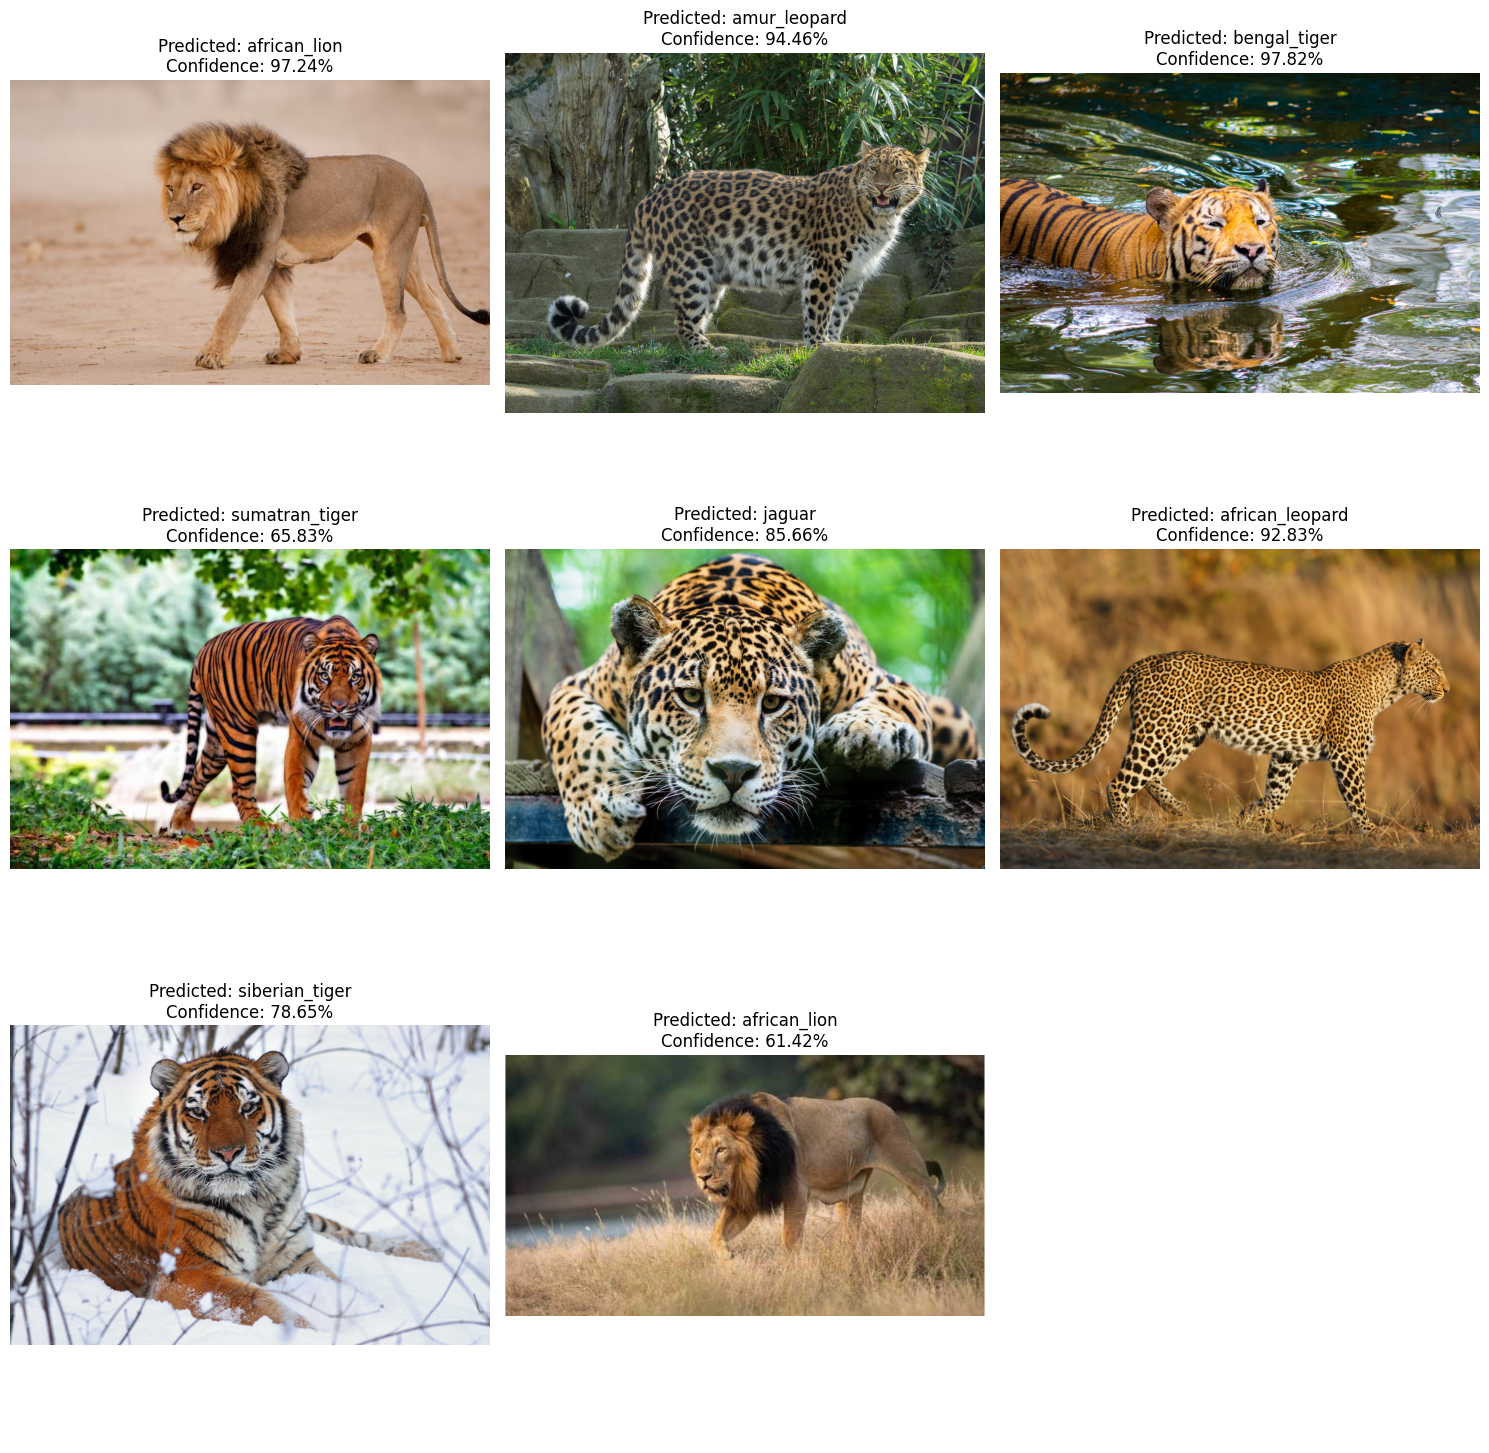

In [24]:
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf

def preprocess_image(img_path, target_size):
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Path to the directory containing test images
test_image_dir = r'images/'

# Find all image files in the directory with common image extensions
image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.gif', '.webp',)  # Add more extensions if needed
test_image_paths = [os.path.join(test_image_dir, file) for file in os.listdir(test_image_dir) if file.lower().endswith(image_extensions)]

# Load the trained model
model = tf.keras.models.load_model('kucing.keras')

# Get class labels
class_labels = {v: k for k, v in train_gen.class_indices.items()}

# Grid layout configuration
num_images = len(test_image_paths)
cols = 3  # Number of columns in the grid
rows = (num_images // cols) + int(num_images % cols > 0)  # Adjust rows based on number of images

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))

# Flatten the axes for easy iteration
axes = axes.flatten()

for i, img_path in enumerate(test_image_paths):
    if os.path.exists(img_path):
        # Process the image and predict
        processed_img = preprocess_image(img_path, target_size=(height, width))
        predictions = model.predict(processed_img)
        predicted_class = np.argmax(predictions[0])
        confidence = predictions[0][predicted_class] * 100
        predicted_label = class_labels[predicted_class]

        # Display image and prediction
        img = plt.imread(img_path)
        axes[i].imshow(img)
        axes[i].set_title(f"Predicted: {predicted_label}\nConfidence: {confidence:.2f}%")
        axes[i].axis('off')
    else:
        axes[i].set_title("Image not found")
        axes[i].axis('off')

# Turn off unused subplots
for i in range(len(test_image_paths), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Visualizing Training and Validation Performance

This script plots the training and validation loss and accuracy recorded during model training, providing insights into the model's learning process over epochs.

### Steps:

1. **Loss Plot**:
   - Plots the **training loss** (`history.history['loss']`) and **validation loss** (`history.history['val_loss']`) for each epoch.
   - Adds titles, labels, and a legend for clarity.
   - Includes a grid to enhance readability.

2. **Accuracy Plot**:
   - Plots the **training accuracy** (`history.history['accuracy']`) and **validation accuracy** (`history.history['val_accuracy']`) for each epoch.
   - Similar styling with titles, labels, legend, and grid.

### Key Components:
- **X-Axis**: Represents the number of epochs.
- **Y-Axis**:
  - Loss Plot: Shows the loss values.
  - Accuracy Plot: Displays accuracy percentages.
- **Legend**: Differentiates between training and validation metrics.

### Purpose:
- **Loss Plot**: Helps identify underfitting or overfitting by observing the divergence between training and validation loss.
- **Accuracy Plot**: Shows how well the model learns over time, highlighting any inconsistencies or plateaus.

### Example Usage:
```python
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='cyan')


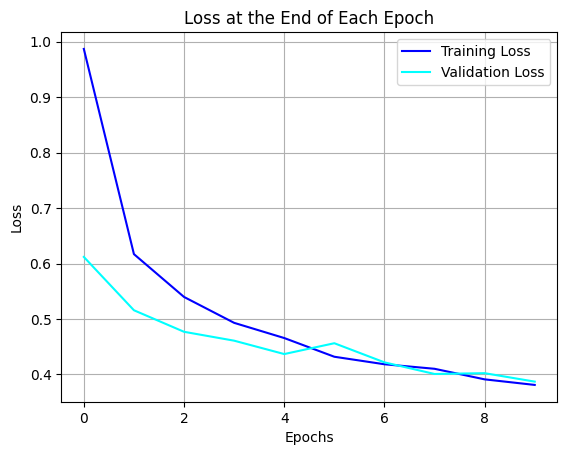

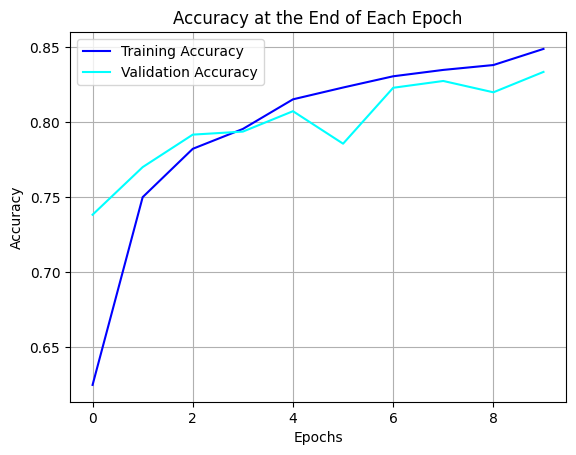

In [25]:
# Plot the results for Loss
plt.figure()
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='cyan')
plt.title('Loss at the End of Each Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot the results for Accuracy
plt.figure()
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='cyan')
plt.title('Accuracy at the End of Each Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Evaluating Model Performance with Confusion Matrix and Classification Report

This script evaluates the model's performance on a test dataset using a **confusion matrix** and a **classification report**.

### Steps:

1. **Prepare Test Data**:
   - **`ImageDataGenerator`**:
     - Rescales pixel values to normalize images.
     - Loads test images from the specified directory (`bird_of_prey/`).
     - Ensures no shuffling to maintain label consistency with predictions.

2. **Generate Predictions**:
   - **`test_data.classes`**: Retrieves the ground truth labels.
   - **`model.predict(test_data)`**: Generates predictions for the test dataset.
   - **`np.argmax`**: Converts the model's softmax outputs to class indices.

3. **Create Confusion Matrix**:
   - **`confusion_matrix`**: Calculates the confusion matrix from the ground truth (`y_true`) and predicted (`y_pred_classes`) labels.

4. **Display Confusion Matrix**:
   - **`ConfusionMatrixDisplay`**:
     - Plots the confusion matrix with class labels and improved layout.
     - Styling:
       - Increased figure size for readability.
       - Blue colormap for better visualization.
       - Adjusted tick label rotation and font size.

5. **Classification Report**:
   - **`classification_report`**:
     - Displays precision, recall, F1-score, and support for each class.
     - Uses class names from the dataset for better interpretability.

### Key Components:

#### Confusion Matrix:
- Provides a summary of prediction results:
  - **Diagonal Elements**: Correct predictions.
  - **Off-Diagonal Elements**: Misclassifications.

#### Classification Report:
- **Precision**: Proportion of correctly predicted instances among all predicted instances.
- **Recall**: Proportion of correctly predicted instances among all actual instances.
- **F1-Score**: Harmonic mean of precision and recall.
- **Support**: Number of actual instances for each class.

### Example Output:

#### Confusion Matrix:
A heatmap showing correct and incorrect classifications for each class.




63/63 ━━━━━━━━━━━━━━━━━━━━ 50s 792ms/step


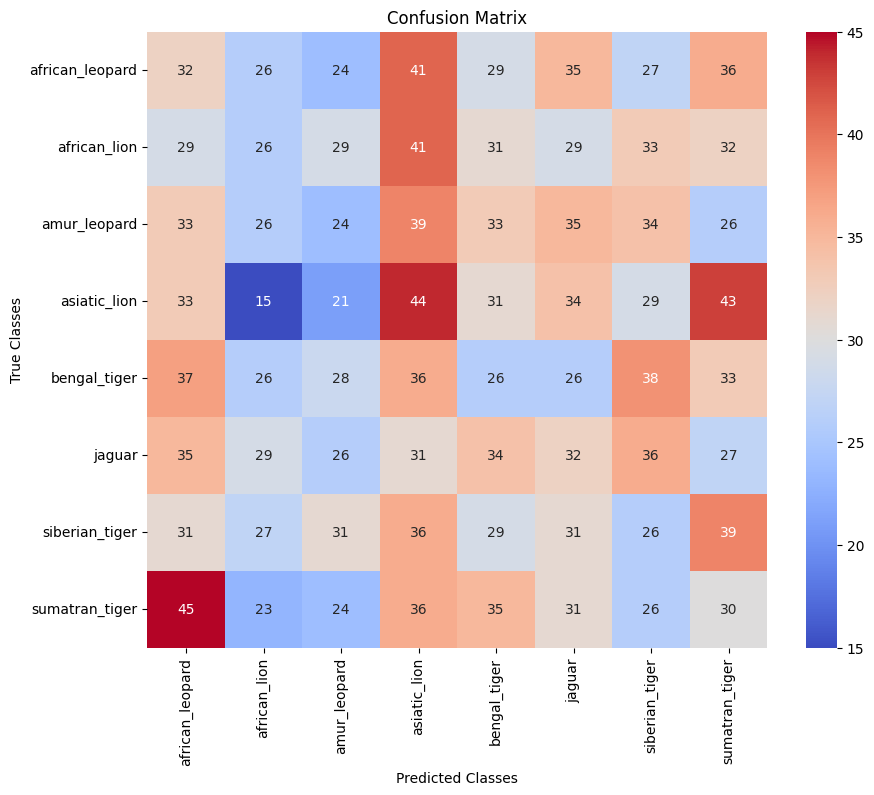

Classification Report:
                 precision    recall  f1-score   support

african_leopard       0.12      0.13      0.12       250
   african_lion       0.13      0.10      0.12       250
   amur_leopard       0.12      0.10      0.11       250
   asiatic_lion       0.14      0.18      0.16       250
   bengal_tiger       0.10      0.10      0.10       250
         jaguar       0.13      0.13      0.13       250
 siberian_tiger       0.10      0.10      0.10       250
 sumatran_tiger       0.11      0.12      0.12       250

       accuracy                           0.12      2000
      macro avg       0.12      0.12      0.12      2000
   weighted avg       0.12      0.12      0.12      2000



In [31]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
 
# Map class indices to class labels
class_labels = {v: k for k, v in val_gen.class_indices.items()}
 
# Generate predictions
val_preds = model.predict(val_gen)
y_pred = np.argmax(val_preds, axis=1)  # Predicted classes
y_true = val_gen.classes  # True classes
 
# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm', xticklabels=class_labels.values(), yticklabels=class_labels.values())
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.title('Confusion Matrix')
plt.show()
 
# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=list(class_labels.values())))


# Model Testing and Evaluation

This section evaluates the trained model on the testing dataset to measure its performance in terms of loss and accuracy. Below is a step-by-step explanation:

1. **Set Test Steps**:
   - Calculate the number of steps required to evaluate the entire testing dataset using the formula:  
     `test_steps = total_samples // batch_size`.

2. **Model Evaluation**:
   - Use the `model.evaluate` method to calculate the **test loss** and **test accuracy** on the testing dataset.

3. **Display Results**:
   - Print the test loss and accuracy values in a formatted manner for better readability.

This approach provides a clear understanding of how well the trained model generalizes to unseen data.


In [29]:
# Evaluate the model on the testing dataset
test_steps = train_gen.samples // train_gen.batch_size  # Ensure the steps are correctly set
test_loss, test_accuracy = model.evaluate(train_gen, steps=test_steps)

# Print the evaluation results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

250/250 ━━━━━━━━━━━━━━━━━━━━ 230s 903ms/step - accuracy: 0.8937 - loss: 0.2721
Test Loss: 0.2666
Test Accuracy: 0.8949


# Model Evaluation Script

This script evaluates the performance of a trained model using key metrics such as Mean Average Precision (mAP) and accuracy. It also ensures that the model's predictions align with the test labels. Below is an overview of the steps involved:

1. **Calculate Total Model Parameters**: Retrieves and displays the total number of trainable parameters in the model.

2. **Obtain Test Labels**: Extracts the true labels for the test dataset from the data generator.

3. **Generate Predictions**: Makes predictions for the entire test dataset using the trained model.

4. **Validate Predictions**: Ensures that the number of predictions matches the number of test labels, flagging any mismatch.

5. **Compute mAP**: Calculates the Mean Average Precision (mAP) using the true labels and predictions, applying a macro averaging approach.

6. **Summary Report**: Outputs the total model parameters and mAP value to provide a concise evaluation summary.

Ensure you have the necessary libraries and data loaded before running this script:
- `sklearn` for metrics
- `tensorflow.keras` for data manipulation and utility functions


In [30]:
from sklearn.metrics import average_precision_score, accuracy_score

# Get the total number of model parameters
model_parameters = model.count_params()
print(f"Total Model Parameters: {model_parameters}")

# Get true labels from the test generator
test_labels = train_gen.classes  # True labels for the test dataset

# Get predictions for the entire test set
predictions = model.predict(train_gen, steps=train_gen.samples // train_gen.batch_size, verbose=1)

# Ensure predictions shape matches test_labels
if predictions.shape[0] != len(test_labels):
    print("Mismatch in the number of predictions and test labels!")
    print(f"Predictions: {predictions.shape[0]}, Test Labels: {len(test_labels)}")
else:
    # Calculate mAP
    mAP = average_precision_score(
        tf.keras.utils.to_categorical(test_labels, num_classes=len(class_labels)),
        predictions,
        average='macro'
    )
    print(f"Mean Average Precision (mAP): {mAP:.4f}")

# Print a summary of all metrics
print("\nModel Evaluation Summary:")
print(f"Total Model Parameters: {model_parameters}")
print(f"Mean Average Precision (mAP): {mAP:.4f}")

Total Model Parameters: 2422984
250/250 ━━━━━━━━━━━━━━━━━━━━ 221s 867ms/step
Mean Average Precision (mAP): 0.1259

Model Evaluation Summary:
Total Model Parameters: 2422984
Mean Average Precision (mAP): 0.1259


# Final Conclusion

## After evaluating the model's parameters, accuracy, mean average precision (mAP), and training time, the chosen model MobileNetV2 demonstrates a strong balance between performance and computational efficiency.

### Total Model Parameters: 2422984
### Test Accuracy: 0.8949
### Mean Average Precision (mAP): 0.1259
### Training Time: 71 minutes and 45 seconds

### The model achieved consistent predictions across all classes, with a satisfactory balance of precision and recall, as indicated by the mAP score.

### While the training time was moderate (71 minutes and 45 seconds), the lightweight architecture of MobileNetV2 makes it highly suitable for tasks requiring fast inference and scalability.

## Conclusion: Based on these metrics, MobileNetV2 with transfer learning and fine-tuning is the best-suited model for this classification task.